# Neural Network for Custom Image
- **Custom Images**: are images present in the original for in the folder.
- We're going to design a neural network for a custom image.
  
  ![alt text](Images/image-2.png)
  - Inside a folder we have 2 kinds of images cross and circle, we will design a neural network to classify this images.
    - some cross and circles are not complete therefor hey will create a challenge for the neural network.
      - Therefore in this dataset we will have two categories:
        - Cross
        - Circle
      - These images are in the original form i.e. they are not in the form of numpy array or csv file.
### The design of the Neural Network
- The design of the Neural Network will look like this:

    ![alt text](Images/image-3.png)
- The channel of these images are 3 because they are in RGB format. i.e. color image
    - 1 channel is:   116 * 116
    - Total number of pixels = 116 * 116 * 3 = 40368
- I.e. 40368 are the feature of each image.
- 2 represent the number of labels in the dataset. i.e. cross and circle.
- For custom images we cannot use train_test_split in order to spit the dataset int train and test set.
  - therefore we need to install splot-folders for training and testing the dataset.

In [1]:
# !pip install split-folders

# 0. Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import style
style.use('default')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchsummary import summary                                # <= to see the summary of the model

import splitfolders

### &nbsp;&nbsp;&nbsp;&nbsp; Checking the device if Cuda is available

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# 1. Transforming the Images into Pytorch Tensor

---



In [4]:
transform = transforms.Compose([transforms.ToTensor()])

### &nbsp;&nbsp;&nbsp;&nbsp; Mounting the drive

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# %cd /content/drive/MyDrive/Circle_Cross

# 2. Split the folder into training and testing the dataset
- If we have a dataset in the form of images present in a folder, we can use the splitfolders library i.e. splitfolders() function in order to split the dataset into training and testing the dataset.
- For that we also have to create a new folder 'TrainTes' where we will store the training and testing components of the dataset.

In [7]:
splitfolders.ratio("Circle_Cross", output = "TrainTest", seed=1337,         # <= Splitfolder will split our original folder into training and testing        
                   ratio=(.8, 0.2), group_prefix = None, move = False)      # <= Default value
                                                                            # <= 0.8 = 80% for train, 0.2 = 20% for test
                                                                            # <= We create a folder called TrainTest, and it will contain the training and ......
                                                                            # <= ..... the testing i.e. validation folder. each folder contains two other folders.
                                                                            # <= group_prefix = None, move = False

# 3. Converting the image folder into Pytorch Tensor Dataset

In [8]:
# Train Dataset
Tensor_train_dataset = datasets.ImageFolder('TrainTest/train', transform = transform)        # <= ImageFolder is a function since we have the images in a folder
                                                                                             # <= Training and validation are present in the same folder i.e. TrainTest
                                                                                             # <= transform = transform, will transform the images into the tensor that will be used with the NN.

# Test Dataset
Tensor_test_dataset = datasets.ImageFolder('TrainTest/val', transform = transform)

# 4. Creating the DataLoader & Pushing the Tensor Dataset into it.
- **Note**: We can not perform cross validation because we have to push the dataset into the dataloader object.

In [ ]:
# manual seed: is used to reproduce the same result, every time we run the code
torch.manual_seed(42)

# Creating the train dataloader
train_loader = DataLoader(Tensor_train_dataset, batch_size = 32, shuffle = True, drop_last = True)        # <= shuffling: will randomize the order after each batch when training to avoid Overfitting
                                                                                                            # <= During shuffling, cross validation will be performed
                                                                                                            # 9000 / 32 = 281.25 therefore the remainder i.e. 0.25 will be drop.

# Creating the test dataloader
test_loader = DataLoader(Tensor_test_dataset, batch_size = 32, drop_last = True)

# Creating the class names
class_names = Tensor_train_dataset.classes

# Display the class/label names
print(class_names)

# Display the dataset length
print(f'Training dataset length: {len(Tensor_train_dataset)}')        
print(f'Testing dataset length: {len(Tensor_test_dataset)}')            



['circles', 'crosses']
Training dataset length: 1599
Testing dataset length: 401


# 5. Visualizing Few Batch of Images.

In [10]:
for images, labels in train_loader:
    break

images.shape

torch.Size([32, 3, 116, 116])

- we can see that we have a batch of 32 images with 3 channels i.e. RGB 
- and size: of the image is 116 * 116.
- And the Image is in 4D tensor i.e. (batch_size, channel, height, width), but for NN we need a data in 2D tensor i.e. (batch_size, feature) format.

In [11]:
labels

tensor([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1])

- We can the labels of the first batch of images. i.e. the labels of the first 32 images.
- We have 2 labels i.e. 0 and 1. i.e. cross and circle.

Labels: [1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1]
Class: crosses crosses crosses circles crosses circles circles crosses circles crosses crosses crosses crosses circles crosses crosses circles crosses circles circles crosses crosses circles circles circles circles crosses crosses circles circles crosses crosses


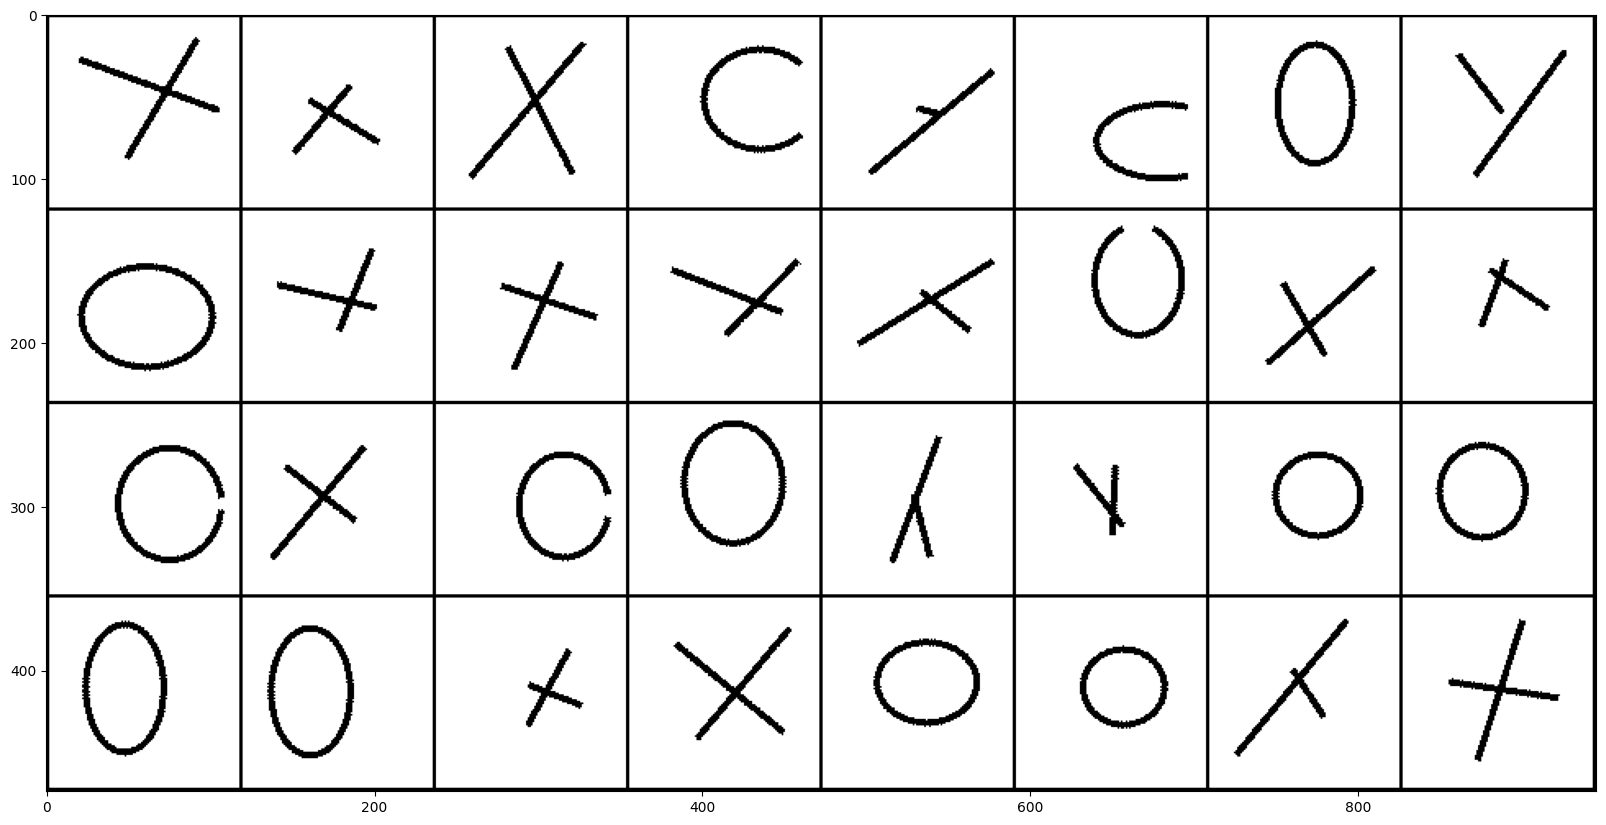

In [12]:
# Printing the labels
print('Labels:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels.numpy()]))

im = make_grid(images)

# Print the images
plt.figure(figsize = (20, 16))
# plt.axis('off')
# plt.imshow(im.permute(1, 2, 0))      # or
plt.imshow(im.numpy().transpose((1, 2, 0)))
# plt.show()


# 6. Creating the ANN Model

In [13]:
######################################## Creating the ANN model  ########################################
########################################## ➡️Sequential Form⬅️ #########################################

ANN_custom = nn.Sequential(
    nn.Linear(40368, 4096),          # 3 * 116 * 116
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 2048),
    nn.ReLU(),
    nn.Linear(2048, 1024), 
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 2)            #<- Has a build-in sigmoid function after the output layer
)

ANN_custom

Sequential(
  (0): Linear(in_features=40368, out_features=4096, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4096, out_features=4096, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4096, out_features=2048, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2048, out_features=1024, bias=True)
  (7): ReLU()
  (8): Linear(in_features=1024, out_features=512, bias=True)
  (9): ReLU()
  (10): Linear(in_features=512, out_features=256, bias=True)
  (11): ReLU()
  (12): Linear(in_features=256, out_features=128, bias=True)
  (13): ReLU()
  (14): Linear(in_features=128, out_features=2, bias=True)
)

# 7. Training and Testing the Model

### &nbsp;&nbsp;&nbsp;&nbsp; 7.1 Setting the Parameters of the model

In [14]:
# Setting the Learning rate
learning_rate = 0.001

# Setting the Loss Function
loss_function = nn.CrossEntropyLoss()                                                           # <= We use CrossEntropyLoss() since we're performing classification

# Setting the Optimizer
optimizer = torch.optim.SGD(ANN_custom.parameters(), momentum = 0.9, lr = learning_rate)          # <= SGD = Stochastic Gradient Descent as optimizer
                                                                                                  # <= Momentum will increase the speed of optimization. max. is 1, here we set it to 0.9
# Placing the ANN_model on GPU
ANN_custom = ANN_custom.to(device)

### &nbsp;&nbsp;&nbsp;&nbsp; 7.2 Training and Testing the Model

In [ ]:
# Number of times we want to pass the entire dataset in the ANN model
number_of_epochs = 61

# Creating a 1D tensor filled with zeros, in order to track/store the losses at each  epoch
losses = torch.zeros(number_of_epochs)                                       # <- initializing the losses tensor with 1000 zeros and at each epoch we'll store the loss
                                                                             # <- During the forward propagation we'll calculate the loss and store it in the losses tensor.

# Initializing accuracy
train_accuracy = []
test_accuracy  = []

# Using a for loop to pass the dataset 1000 times into the model
for epochi in range(number_of_epochs):

    # Putting the model in the training mode
    ANN_custom.train()

    # putting the model in the device  📍📍Added📍📍
    ANN_custom.to(device)
    
    
    # for loop for training in batches
    batch_accuracy = []
    batch_loss     = []

    # The for loop ensure that during a single run only 32 sample will be passed
    for X,Y in train_loader:

      # Reshaping from  4D to 2D 📍📍added📍📍              # <= to transform into 2D we have to multiple the last 3 dimension together i.e. 3 * 116 * 116 = 40368
      X = X.reshape(32, 40368)                                # <= 32 is the batch size
      
      # Placing feature on device, since the model is in GPU feature should also be in GPU
      X = X.to(device)

      # Placing labels on device, since the model is in GPU feature should also be in GPU
      Y = Y.to(device)



      # Forward Propagation
      y_pred = ANN_custom(X)                 # <- We pass the features x into the model and then the output of the model is our predictions y_pred.

      # We calculate/compute the loss
      loss = loss_function(y_pred, Y)                  # <- To calculate/compute the loss we pass the predictions y_pred and the true values y into the loss_function()...
                                                     # ... for that particular training epoch.



      # Backward  Propagation                          # <- Backward Propagation is the process of calculating the gradients of the loss function with respect to the model parameters.

      # Initialize the gradients to zero
      optimizer.zero_grad()                            # <- zero_grad() restart the gradients to zero at each epoch, so that the gradients/losses are not accumulated.

      # Calculating the gradients
      loss.backward()                                  # <- loss.backward() is used to calculate the gradients of the loss with respect to the parameters of the model.


      # Updating the model parameters
      optimizer.step()                                 # <- The optimizer.step() is used to update the model parameters so that the error could be minimized.

      # Append Batch loss after performing the batch training
      batch_loss.append(loss.item())

      # Putting y_pred back to cpu
      y_pred = y_pred.cpu()
      Y = Y.cpu()


      # Computing the Batch accuracy
      accuracy = 100*torch.mean((torch.argmax(y_pred, axis = 1) == Y ).float())
      # Appending the batch accuracy
      batch_accuracy.append(accuracy)

      ####### Batch concluded

    # Average training accuracy(outside the batch loop)
    train_accuracy.append(np.mean(batch_accuracy))                # <= traiNIng accuracy is the average of the batch accuracy.

    # Total Accuracy is the mean of the batch_loss
    losses[epochi] = np.mean(batch_loss)                          # <- Storing the loss at each epoch in a tensor losses. i.e. Put the computed loss into the epoch-th position of the losses tensor.
                                                                  # <- at each epoch/iteration we'll replace the respective zero with the calculated loss.


##################################################################################➡️ testing the model ⬅️##########################################################################################

    # Putting the model on the Testing Mode
    ANN_custom.eval()

    # ❌ Passing all the samples at once from the test_dataloader to the train model
    # X, Y = next(iter(test_loader))

    # ❌ Pushing X and Y in GPU
    # X = X.to(device)
    # Y = Y.to(device)

    # Deactivating the gradient since during back propagation we don't need the gradient
    with torch.no_grad():

      # 📍📍Added📍📍
      for X, Y, in test_loader:
        
        # Reshaping from 4D to 2D
        X = X.reshape(32, 40368)
        X = X.to(device)
        Y = Y.to(device)


        # Passing the testing data to the model
        y_pred = ANN_custom(X)                           # <= Here we will obtain the prediction

        # Putting the prediction back to cpu
        y_pred = y_pred.cpu()
        Y = Y.cpu()

    # Appending the test accuracy
    test_accuracy.append(100 * torch.mean((torch.argmax(y_pred, dim = 1) == Y).float()))
    # printing the losses after every 10 epochs
    if (epochi % 5) == 0:
      print(f'epochs: {epochi}, loss: {loss.item() : 2.2f}')            #📍📍Added📍📍


epochs: 0, loss:  0.69
epochs: 5, loss:  0.69
epochs: 10, loss:  0.69
epochs: 15, loss:  0.69


KeyboardInterrupt: 

# 8. Visualizing the results

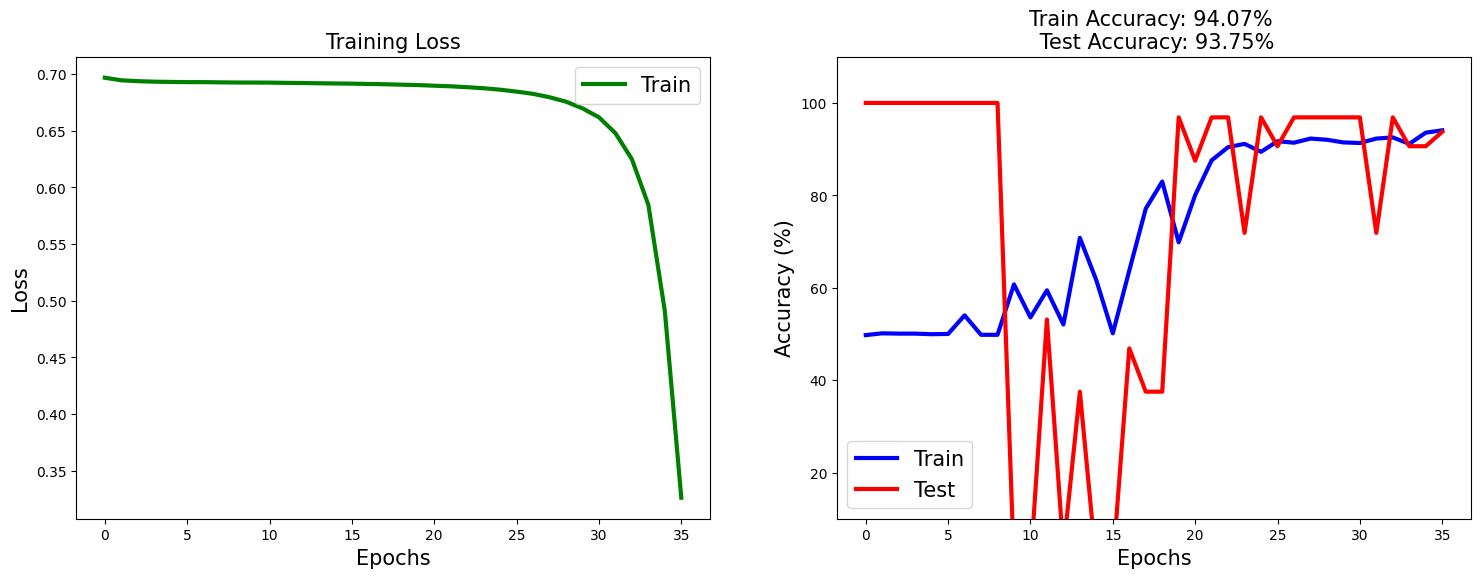

In [ ]:
# Visualize the loss and accuracies after the training loop
fig, ax = plt.subplots(1, 2, figsize = (18, 6))       # <= 1 row, 2 column

ax[0].plot(losses, 'g', lw = 3, label = 'Train')      # <= ax[0] means we're plotting on the 1st column, i.e. losses on the first column, g = green
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)
ax[0].legend(fontsize = 15)

ax[1].plot(train_accuracy, 'b', lw = 3, label = 'Train')   # <= ax[1] means we're plotting on the 2nd column
ax[1].plot(test_accuracy, 'r', lw = 3, label = 'Test')
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim(10, 110)                                    # <= Setting the y limit between 10 and 110 so that we can clearly see the accuracy
ax[1].set_title(f'Train Accuracy: {train_accuracy[-1]:.2f}% \n Test Accuracy: {test_accuracy[-1]:.2f}%', fontsize = 15)       # <= Printing the final values
ax[1].legend(fontsize = 15)

plt.show()